# Evaluation

## Imports

In [1]:
# Import external libraries
import os
import torch
from torchinfo import summary
from pathlib import Path
import torch.nn as nn
import pandas as pd

In [2]:
# Import internal libraries
from melanoma_classification.model import get_dermmel_classifier_v1
from utils.dermmel import DermMel
from melanoma_classification.utils import (
    production_transform,
    get_device
)
from evaluation.evaluator import (
    visualize_loss,
    visualize_f1_precision_recall,
    visualize_accuracy,
    create_evaluation_report,
    visualize_confusion_matrix,
    visualize_model_confidence
)

## Preparations

In [3]:
# Init device
device = get_device()
print(f"Using device: {device}")

Using device: mps


In [4]:
# Set paths
figure_path = Path("evaluation") / "images"
checkpoint_base_path = Path("checkpoints") / "dermmel"
training_metrics_filename = "metrics.csv"
final_model_path = Path('..') /  "src" / "melanoma_classification" / "weights"
final_model_path.mkdir(exist_ok=True)


### Create & read in model from checkpoints

In [5]:
checkpoint_path = checkpoint_base_path / "checkpoint_epoch_20.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

/var/folders/kt/fz2n770s5nl7x9529l2zhpww0000gn/T/ipykernel_28008/3584975421.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

In [6]:
vit = get_dermmel_classifier_v1()
vit.load_state_dict(checkpoint['model_state_dict'])

# Load the model
summary(vit, input_size=(1, 3, 224, 224), device=device)

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 2]                    152,064
├─PatchEmbeddingCNN: 1-1                      [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
├─Dropout: 1-2                                [1, 197, 768]             --
├─ModuleList: 1-3                             --                        --
│    └─TransformerEncoderLayer: 2-2           [1, 197, 768]             --
│    │    └─MultiHeadSelfAttention: 3-1       [1, 197, 768]             2,362,368
│    │    └─LayerNorm: 3-2                    [1, 197, 768]             1,536
│    │    └─Sequential: 3-3                   [1, 197, 768]             4,722,432
│    │    └─LayerNorm: 3-4                    [1, 197, 768]             1,536
│    └─TransformerEncoderLayer: 2-3           [1, 197, 768]             --
│    │    └─MultiHeadSelfAttention: 3-5       [1, 197, 768]      

### Create test dataset & dataloader

In [7]:
test_dataset = DermMel(
    '../data',
    split='simple',
    transform=production_transform()
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0
)

### Read-in training metrics

In [8]:
training_metrics = pd.read_csv(checkpoint_base_path / training_metrics_filename)
training_metrics.head()

,epoch,train_loss,train_acc,val_loss,val_acc,train_f1,train_precision,train_recall,val_f1,val_precision,val_recall
0,1,0.078971,63.443175,0.072160,67.181359,0.606152,0.656974,0.562629,0.637744,0.711618,0.577765
1,2,0.074619,67.580977,0.072348,70.550253,0.643761,0.714384,0.585845,0.738077,0.664568,0.829871
2,3,0.073571,68.320539,0.069189,70.634475,0.662679,0.708591,0.622355,0.683222,0.741617,0.633352
3,4,0.072561,69.097547,0.071152,68.641213,0.670197,0.718509,0.627972,0.661618,0.718421,0.613139
4,5,0.072297,69.060101,0.067713,71.925884,0.668472,0.719965,0.623853,0.687109,0.775972,0.616508


## Training analysis

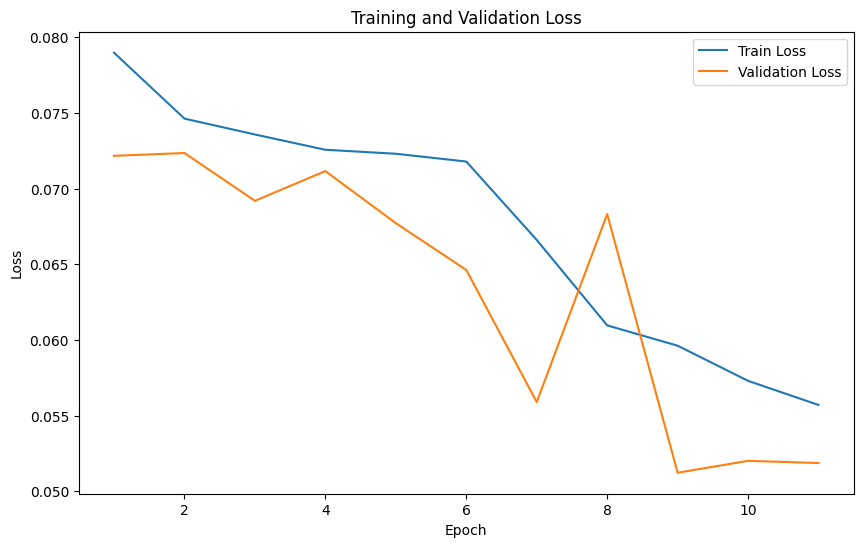

In [9]:
visualize_loss(training_metrics, figure_path / "loss.png")

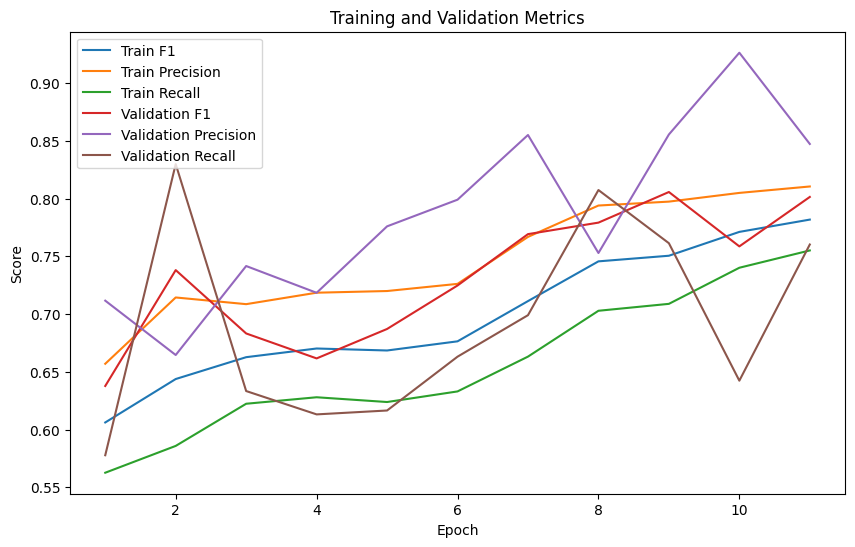

In [10]:
visualize_f1_precision_recall(training_metrics, figure_path / "f1_precision_recall.png")

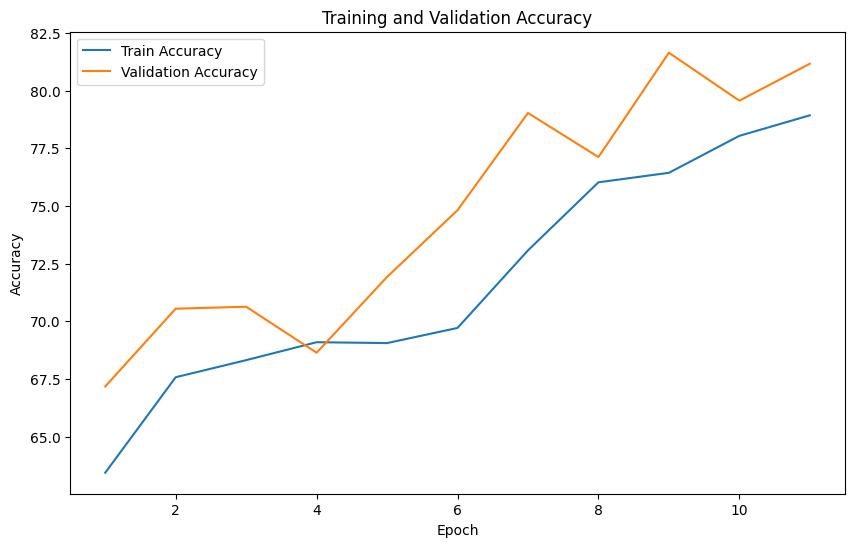

In [11]:
visualize_accuracy(training_metrics, figure_path / "accuracy.png")

## Test model

In [12]:
evaluation_report = create_evaluation_report(
    vit,
    test_dataloader,
    test_dataset.classes,
    device
)

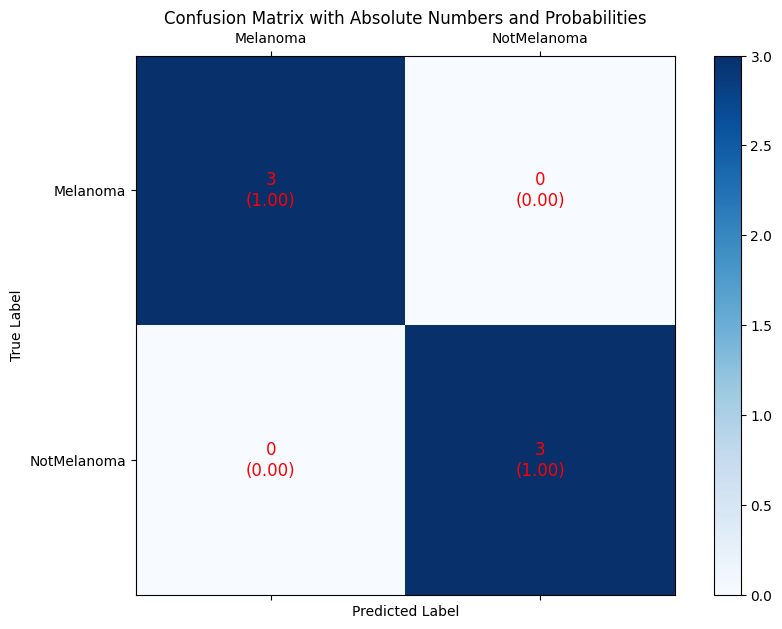

In [13]:
visualize_confusion_matrix(
    evaluation_report,
    test_dataset.classes,
    figure_path / "confusion_matrix.png"
)

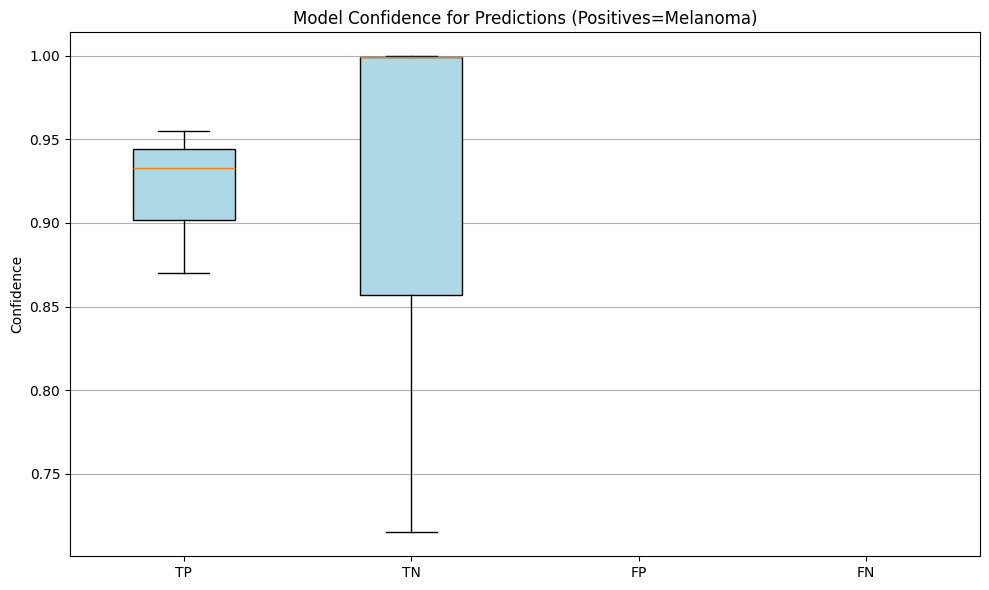

In [14]:
visualize_model_confidence(
    evaluation_report,
    figure_path / "model_confidences.png"
)

## Save only the model

In [15]:
# Save the model to production folder
torch.save(vit.state_dict(), final_model_path / 'vit.pth')